# Steps involved in making recommendation system:
* Importing neccessary libraries
* Data collection
* Data importing
* Data cleaning and preprocessing
* Data analysis and visualization
* Machine learning model implementation
    1. Content-based filtering
    2. Collaborative filtering
* Model evaluation
* Hyperparameter tuning and model evaluation again

Dataset used:
For this project i am using the movielens small dataset: https://grouplens.org/datasets/movielens/latest/


In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# this is required to make the plot appear inside the notebook


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import mean_squared_error

# from sklearn.model_selection import train_test_split
from wordcloud import WordCloud


# importing surprise library
from surprise.model_selection import train_test_split

from surprise import SVD, Reader, KNNBasic
from surprise import Dataset, dump
from surprise import accuracy
import pickle

import warnings; warnings.simplefilter('ignore')

Description of the tmdb dataset
credits dataset:
* movie_id - A unique identifier for each movie.
* cast - The name of lead and supporting actors.
* crew - The name of Director, Editor, Composer, Writer etc.

movies dataset:
* budget - The budget in which the movie was made.
* genre - The genre of the movie, Action, Comedy ,Thriller etc.
* homepage - A link to the homepage of the movie.
id - This is infact the movie_id as in the first dataset.
* keywords - The keywords or tags related to the movie.
* original_language - The language in which the movie was made.
* original_title - The title of the movie before translation or adaptation.
* overview - A brief description of the movie.
* popularity - A numeric quantity specifying the movie popularity.
* production_companies - The production house of the movie.
* production_countries - The country in which it was produced.
* release_date - The date on which it was released.
* revenue - The worldwide revenue generated by the movie.
* runtime - The running time of the movie in minutes.
* status - "Released" or "Rumored".
* tagline - Movie's tagline.
* title - Title of the movie.
* vote_average - average ratings the movie recieved.
* vote_count - the count of votes recieved.

In [3]:
# df1=pd.read_csv('TMDB Dataset/tmdb_5000_movies.csv')
# df2=pd.read_csv('TMDB Dataset/tmdb_5000_credits.csv')

In [4]:
# df1.head()

In [5]:
# df2.head()

# movie lens dataset

In [6]:
linksdf=pd.read_csv('Movielens dataset/links.csv')
tagsdf=pd.read_csv('Movielens dataset/tags.csv')
moviesdf=pd.read_csv('Movielens dataset/movies.csv')
ratingsdf=pd.read_csv('Movielens dataset/ratings.csv')

In [7]:
linksdf.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
tagsdf.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
moviesdf.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
ratingsdf.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Merging the dataset and analysing as one dataset

In [11]:
movies_rating_df = pd.merge(moviesdf, ratingsdf, on='movieId')

In [12]:
movies_rating_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [13]:
movies_rating_df.shape

(100836, 6)

In [14]:
movies_rating_df.columns


Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [15]:
movies_rating_df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [16]:
# Analysing the insights of the data
movies_rating_df.describe()

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


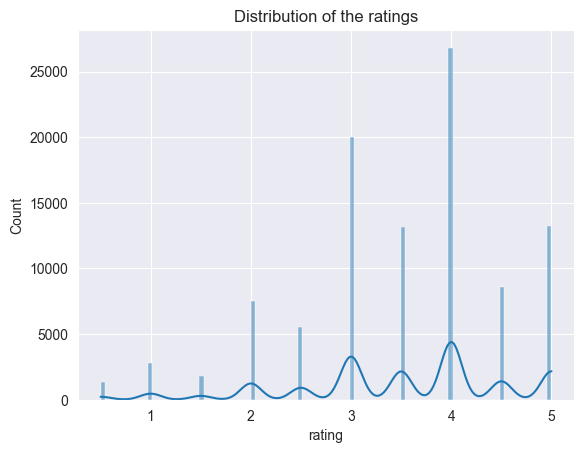

In [17]:
# Data distribution of ratings
sns.histplot(movies_rating_df['rating'], kde=True)
plt.title('Distribution of the ratings')
plt.show()

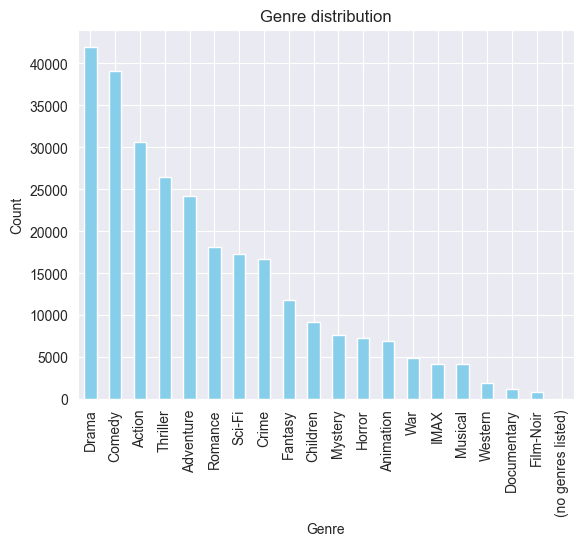

In [18]:
# Genre Analysis
genre_counts=movies_rating_df['genres'].str.split('|', expand=True).stack().value_counts()
genre_counts.plot(kind='bar', color='skyblue')
plt.title("Genre distribution")
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

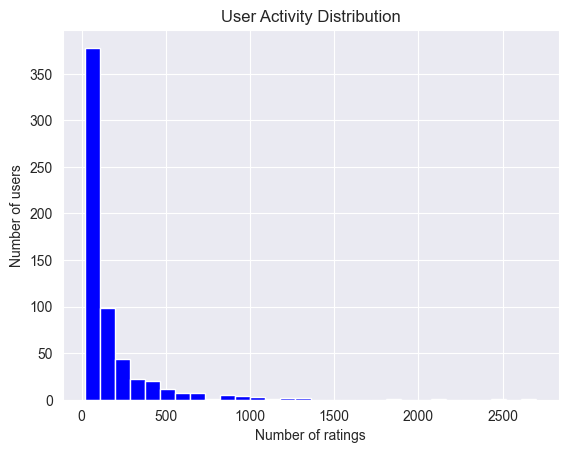

In [19]:
# user activity analysis
# visualising the number of ratings per user
user_activity=movies_rating_df['userId'].value_counts()
user_activity.plot(kind='hist', bins=30, color='blue')
plt.title('User Activity Distribution')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

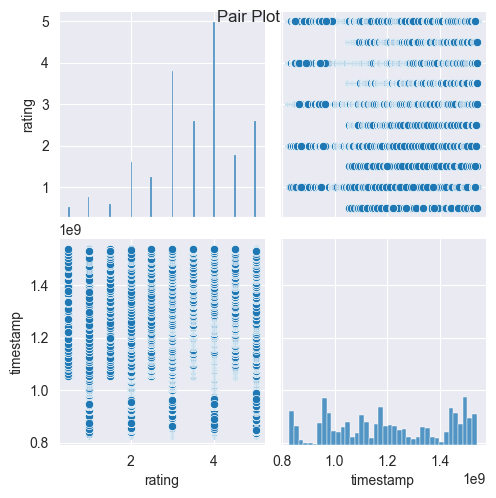

In [20]:
# Ploting pair plot to visualise the realtionship between ratings and timestamp
sns.pairplot(movies_rating_df[['rating', 'timestamp']])
plt.suptitle('Pair Plot')
plt.show()

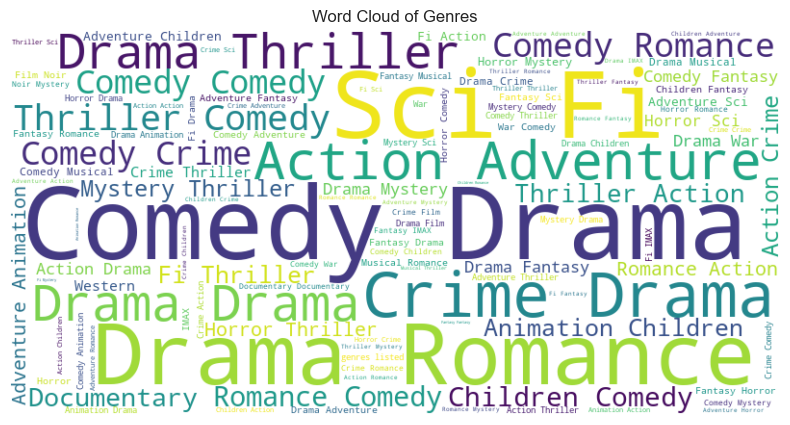

In [21]:
# Plotting a word cloud to find the most common genre in the dataset
genres_text = ' '.join(moviesdf['genres'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(genres_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Genres')
plt.show()

In [22]:
genres_text

'Adventure|Animation|Children|Comedy|Fantasy Adventure|Children|Fantasy Comedy|Romance Comedy|Drama|Romance Comedy Action|Crime|Thriller Comedy|Romance Adventure|Children Action Action|Adventure|Thriller Comedy|Drama|Romance Comedy|Horror Adventure|Animation|Children Drama Action|Adventure|Romance Crime|Drama Drama|Romance Comedy Comedy Action|Comedy|Crime|Drama|Thriller Comedy|Crime|Thriller Crime|Drama|Horror|Mystery|Thriller Action|Crime|Thriller Drama|Sci-Fi Drama|Romance Drama Children|Drama Drama|Romance Adventure|Drama|Fantasy|Mystery|Sci-Fi Crime|Drama Drama Mystery|Sci-Fi|Thriller Children|Drama Crime|Drama Children|Comedy Comedy|Romance Drama Drama|War Action|Crime|Drama Drama Action|Adventure|Fantasy Comedy|Drama|Thriller Drama|Romance Mystery|Thriller Animation|Children|Drama|Musical|Romance Drama|Romance Crime|Mystery|Thriller Comedy|Drama|Romance Adventure|Drama Children|Comedy Drama Drama Comedy|Drama|Romance Adventure|Children|Fantasy Drama|Thriller Drama Comedy|Crime C

# Now creating a content-based recommendation system

# creating a TF-IDF Vectorizer
TF-IDF: Stands for term frequency-inverse document frequency and it a measure, It converts the fraw documents to a matrix of TF-IDF features

In [23]:
# Convert 'movieId' to 'title' using 'moviesdf'
# ratings_with_titles = pd.merge(ratingsdf, moviesdf[['movieId', 'title']], on='movieId')
#
# # Split the data into training and testing sets
# train_data, test_data = train_test_split(ratings_with_titles, test_size=0.2, random_state=42)
#


In [24]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english')

In [25]:
# Fill the missing values and create a TF-IDF matrix
# Preprocess genres to create a single string for each movie
tfidf_matrix=tfidf_vectorizer.fit_transform(moviesdf['genres'])



In [26]:
moviesdf['genres'].value_counts()


genres
Drama                                                  1053
Comedy                                                  946
Comedy|Drama                                            435
Comedy|Romance                                          363
Drama|Romance                                           349
                                                       ... 
Action|Crime|Horror|Mystery|Thriller                      1
Adventure|Animation|Children|Comedy|Musical|Romance       1
Action|Adventure|Animation|Comedy|Crime|Mystery           1
Children|Comedy|Fantasy|Sci-Fi                            1
Action|Animation|Comedy|Fantasy                           1
Name: count, Length: 951, dtype: int64

In [27]:
ratingsdf.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [28]:
# Function for content-based recommendation system
def content_based_recommendation(movie_title, tfidf_matrix, movies_ratings_df):
    try:
        movie_index = movies_ratings_df[movies_ratings_df['title'] == movie_title].index[0]
    except IndexError:
        print(f"Movie with title '{movie_title}' not found in the dataset.")
        return []

    # calculate the cosine similarities between input movies and other movies
    cosine_similarities=linear_kernel(tfidf_matrix[movie_index], tfidf_matrix).flatten()

    # get the indices of movies most similar to input movie
    similar_movie_indices=cosine_similarities.argsort()[:-11:-1] # getting the top 10 similar movies

    # return the title of the recommended movies
    recommended_movies=movies_ratings_df['title'].iloc[similar_movie_indices].tolist()

    similarity_scores = cosine_similarities[similar_movie_indices].tolist()

    return recommended_movies, similarity_scores



In [29]:
# testing the content-based recommender system
user_input='Jumanji (1995)'
recommended_movies,similarity=content_based_recommendation(user_input, tfidf_matrix, moviesdf)
print(f"Recommended movies for {user_input}:")
for movie, score in zip(recommended_movies, similarity):
    print(f"{movie}: Similarity Score = {score}")

Recommended movies for Jumanji (1995):
Golden Compass, The (2007): Similarity Score = 1.0
Pete's Dragon (2016): Similarity Score = 1.0
NeverEnding Story III, The (1994): Similarity Score = 1.0
Gulliver's Travels (1996): Similarity Score = 1.0
Santa Claus: The Movie (1985): Similarity Score = 1.0
Indian in the Cupboard, The (1995): Similarity Score = 1.0
NeverEnding Story II: The Next Chapter, The (1990): Similarity Score = 1.0
Water Horse: Legend of the Deep, The (2007): Similarity Score = 1.0
NeverEnding Story, The (1984): Similarity Score = 1.0
Percy Jackson: Sea of Monsters (2013): Similarity Score = 1.0


In [30]:
moviesdf.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [31]:
len(movies_rating_df['title'].value_counts())

9719

# Implementing recommendation system using collaborative filtering using KNNBasics

In [32]:
ratingsdf.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [33]:
reader=Reader(rating_scale=(1,5))

In [128]:
data=Dataset.load_from_df(ratingsdf[['userId','movieId','rating']], reader)

KeyError: "['title', 'tmdbId'] not in index"

In [35]:
# splitting the dataset into train and test set
trainset, testset=train_test_split(data, test_size=0.25, random_state=42)

In [36]:
# algo=SVD()
# create a KNNBAsic collaborative filtering model: user-based
model=KNNBasic(sim_option={'user_based':True})

In [37]:
model.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [38]:
predictions=model.test(testset)

In [39]:
mse=accuracy.mse(predictions)
rmse=accuracy.rmse(predictions)

MSE: 0.9144
RMSE: 0.9562


In [40]:
# Get the list of items not rated by a specific user
user_id = 123
# Get the list of all items in the dataset
N=10
all_items = trainset.all_items()

# Get the list of items rated by the specific user
rated_items_by_user = [item for item, _ in trainset.ur[trainset.to_inner_uid(user_id)]]

# Get the list of items not rated by the user
items_not_rated_by_user = list(set(all_items) - set(rated_items_by_user))

# Make predictions for the items not rated by the user
item_predictions = [model.predict(user_id, item_id) for item_id in items_not_rated_by_user]

# Sort the predictions by estimated rating
sorted_predictions = sorted(item_predictions, key=lambda x: x.est, reverse=True)

# Get the top N recommendations
top_n_recommendations = sorted_predictions[:N]


In [41]:
top_n_recommendations

[Prediction(uid=123, iid=148, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=467, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=495, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=506, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=633, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=876, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=1151, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=1310, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=1406, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=123, iid=1631, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})]

# implementing SVD algorithm and evaluating the model

In [81]:
# initialize the model
algo=SVD()

In [82]:
# train the model
algo.fit(trainset)


In [83]:
# make prediction
predictions=algo.test(testset)

# evaluating the model using the default parameter
mae=accuracy.mae(predictions)
rmse=accuracy.rmse(predictions)

MAE:  0.6794
RMSE: 0.8834


It seems SVD performed really well as compare to KNNBasic

In [84]:
# Get the list of items not rated by a specific user
user_id = 123
# Get the list of all items in the dataset
N=10
all_items = trainset.all_items()

# Get the list of items rated by the specific user
rated_items_by_user = [item for item, _ in trainset.ur[trainset.to_inner_uid(user_id)]]

# Get the list of items not rated by the user
items_not_rated_by_user = list(set(all_items) - set(rated_items_by_user))

# Make predictions for the items not rated by the user
item_predictions = [algo.predict(user_id, item_id) for item_id in items_not_rated_by_user]

# Sort the predictions by estimated rating
sorted_predictions = sorted(item_predictions, key=lambda x: x.est, reverse=True)

# Get the top N recommendations
top_n_recommendations = sorted_predictions[:N]

In [85]:
top_n_recommendations

[Prediction(uid=123, iid=750, r_ui=None, est=4.528202994450491, details={'was_impossible': False}),
 Prediction(uid=123, iid=1208, r_ui=None, est=4.505680862264781, details={'was_impossible': False}),
 Prediction(uid=123, iid=1272, r_ui=None, est=4.463310621589154, details={'was_impossible': False}),
 Prediction(uid=123, iid=7361, r_ui=None, est=4.460090033324218, details={'was_impossible': False}),
 Prediction(uid=123, iid=908, r_ui=None, est=4.4495655741157645, details={'was_impossible': False}),
 Prediction(uid=123, iid=1204, r_ui=None, est=4.439739220942969, details={'was_impossible': False}),
 Prediction(uid=123, iid=1222, r_ui=None, est=4.4290548923343165, details={'was_impossible': False}),
 Prediction(uid=123, iid=4973, r_ui=None, est=4.422751283292367, details={'was_impossible': False}),
 Prediction(uid=123, iid=904, r_ui=None, est=4.42134661142895, details={'was_impossible': False}),
 Prediction(uid=123, iid=1172, r_ui=None, est=4.408979212231547, details={'was_impossible': F

In [140]:
# Saving the model for later use
model_filename='final_model_svd.pkl'
pickle.dump(algo, open(model_filename, 'wb'))



In [49]:
# Let's explore TMDB dataset
tmdb_df=pd.read_csv('TMDB Dataset/tmdb_5000_credits.csv')
tmdb_df.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [50]:
tmdb_movies=pd.read_csv('TMDB Dataset/tmdb_5000_movies.csv')
tmdb_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [132]:
def recommend_movies(model,no_movies, user_id, all_items,movie_mapping):
    # Get the list of items rated by the specific user
    rated_items_by_user = [item for item, _ in trainset.ur[trainset.to_inner_uid(user_id)]]

    # Get the list of items not rated by the user
    items_not_rated_by_user = list(set(all_items) - set(rated_items_by_user))

    # Make predictions for the items not rated by the user
    item_predictions = [model.predict(user_id, item_id) for item_id in items_not_rated_by_user]

    # Sort the predictions by estimated rating
    sorted_predictions = sorted(item_predictions, key=lambda x: x.est, reverse=True)

    # Get the top N recommendations
    top_n_recommendations = sorted_predictions[:no_movies]

    movie_titles=[]
    predicted_ratings=[]

    for recommendation in top_n_recommendations:
        item_id=str(recommendation.iid)
        movie_title=movie_mapping.get(item_id, 'Unknown Movie')
        movie_titles.append(movie_title)
        predicted_ratings.append(recommendation.est)
        print(f"User:{recommendation.uid}  Movie ID:{item_id}  Movie Title: {movie_title}   Predicted rating: {recommendation.est}")

    return  movie_titles, predicted_ratings

In [133]:
all_items = trainset.all_items()
user_id=123
number_movies=10
movie_mapping = dict(zip(moviesdf['movieId'].astype(str), moviesdf['title']))
movie_title, ratings=recommend_movies(model=algo,no_movies= number_movies, user_id=user_id, all_items=all_items, movie_mapping=movie_mapping)

User:123  Movie ID:750  Movie Title: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)   Predicted rating: 4.528202994450491
User:123  Movie ID:1208  Movie Title: Apocalypse Now (1979)   Predicted rating: 4.505680862264781
User:123  Movie ID:1272  Movie Title: Patton (1970)   Predicted rating: 4.463310621589154
User:123  Movie ID:7361  Movie Title: Eternal Sunshine of the Spotless Mind (2004)   Predicted rating: 4.460090033324218
User:123  Movie ID:908  Movie Title: North by Northwest (1959)   Predicted rating: 4.4495655741157645
User:123  Movie ID:1204  Movie Title: Lawrence of Arabia (1962)   Predicted rating: 4.439739220942969
User:123  Movie ID:1222  Movie Title: Full Metal Jacket (1987)   Predicted rating: 4.4290548923343165
User:123  Movie ID:4973  Movie Title: Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)   Predicted rating: 4.422751283292367
User:123  Movie ID:904  Movie Title: Rear Window (1954)   Predicted rating: 4.42134661142895
User:123  Mo

In [134]:
movie_title

['Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
 'Apocalypse Now (1979)',
 'Patton (1970)',
 'Eternal Sunshine of the Spotless Mind (2004)',
 'North by Northwest (1959)',
 'Lawrence of Arabia (1962)',
 'Full Metal Jacket (1987)',
 "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",
 'Rear Window (1954)',
 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)']

In [125]:
# Create a dictionary to map item IDs to movie information


# Print information for the first recommendation
if recommendations:
    first_recommendation = recommendations[0]
    item_id = str(first_recommendation.iid)
    movie_title = movie_mapping.get(item_id, 'Unknown Movie')
    print(f"User: {first_recommendation.uid}   Movie ID: {item_id}   Movie Title: {movie_title}   Estimated Rating: {first_recommendation.est}")
else:
    print("No recommendations available.")


User: 123   Movie ID: 750   Movie Title: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)   Estimated Rating: 4.528202994450491


In [109]:
moviesdf.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [112]:
moviesdf.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [122]:
print(type(recommendations))

<class 'list'>


In [127]:
for recommendation in recommendations:
    item_id=str(recommendation.iid)
    movie_title=movie_mapping.get(item_id, 'Unknown Movie')
    print(f"User:{recommendation.uid}  Movie ID:{item_id}  Movie Title: {movie_title}   Predicted rating: {recommendation.est}")

User:123  Movie ID:750  Movie Title: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)   Predicted rating: 4.528202994450491
User:123  Movie ID:1208  Movie Title: Apocalypse Now (1979)   Predicted rating: 4.505680862264781
User:123  Movie ID:1272  Movie Title: Patton (1970)   Predicted rating: 4.463310621589154
User:123  Movie ID:7361  Movie Title: Eternal Sunshine of the Spotless Mind (2004)   Predicted rating: 4.460090033324218
User:123  Movie ID:908  Movie Title: North by Northwest (1959)   Predicted rating: 4.4495655741157645
User:123  Movie ID:1204  Movie Title: Lawrence of Arabia (1962)   Predicted rating: 4.439739220942969
User:123  Movie ID:1222  Movie Title: Full Metal Jacket (1987)   Predicted rating: 4.4290548923343165
User:123  Movie ID:4973  Movie Title: Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)   Predicted rating: 4.422751283292367
User:123  Movie ID:904  Movie Title: Rear Window (1954)   Predicted rating: 4.42134661142895
User:123  Mo